In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn catboost lightgbm xgboost optuna streamlit plotly hillclimbers


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.8 MB/s eta 0:00:00
  Created wheel for hillclimbers: filename=hillclimbers-0.1.4-py3-none-any.whl size=4514 sha256=d353267f8d4e47f88142e44dcb6ee7711e9c9163afa9e2d1d088599c7b335907
  Stored in directory: /root/.cache/pip/wheels/13/89/f2/480ae00875e6965c0da829955cdc397f409dec819d854ecdf9
Successfully built hillclimbers


In [2]:
# Cell 1: Import necessary libraries
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from scipy.special import logit
from hillclimbers import climb_hill, partial
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from optuna.samplers import TPESampler
import streamlit as st
import plotly.graph_objects as go

In [3]:
# Cell 2: Configuration
# Cell 2: Configuration
class Config:
    train_path = "/content/train.csv"
    test_path = "/content/test.csv"
    sample_sub_path = "/content/sample_submission.csv"
    original_data_path = "/content/credit_risk_dataset.csv"

    target = "loan_status"
    n_folds = 5
    seed = 42



In [4]:
# Cell 3: Load and explore data
train = pd.read_csv(Config.train_path, index_col="id")
test = pd.read_csv(Config.test_path, index_col="id")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (58645, 12)
Test shape: (39098, 11)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106979,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


In [8]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,39098.0,27.566781,6.032761,20.00,23.00,26.00,30.00,94.00
person_income,39098.0,64060.460842,37955.828705,4000.00,42000.00,58000.00,75885.00,1900000.00
person_emp_length,39098.0,4.687068,3.868395,0.00,2.00,4.00,7.00,42.00
loan_amnt,39098.0,9251.466188,5576.254680,700.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,39098.0,10.661216,3.020220,5.42,7.88,10.75,12.99,22.11
loan_percent_income,39098.0,0.159573,0.091633,0.00,0.09,0.14,0.21,0.73
cb_person_cred_hist_length,39098.0,5.830707,4.072157,2.00,3.00,4.00,8.00,30.00


In [9]:
# Cell 4: Explore categorical features
categorical_features = train.select_dtypes(include=["object"]).columns.tolist()
unique_values = {col: train[col].nunique() for col in categorical_features}
for col, value in unique_values.items():
    print(f"{col}: {value} unique values")

person_home_ownership: 4 unique values
loan_intent: 6 unique values
loan_grade: 7 unique values
cb_person_default_on_file: 2 unique values


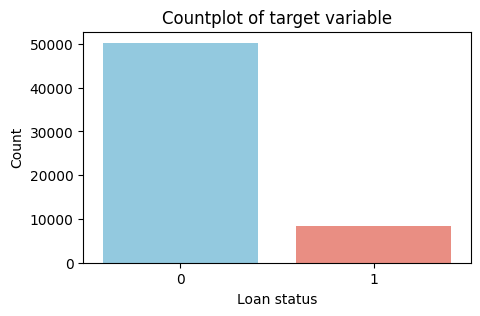

In [10]:
# Cell 5: Visualize target variable
plt.figure(figsize=(5,3))
sns.countplot(data=train, x=Config.target, palette={'0': 'skyblue', '1': 'salmon'})
plt.title("Countplot of target variable")
plt.xlabel("Loan status")
plt.ylabel("Count")
plt.show()

In [11]:
train["loan_status"].value_counts(normalize=True).round(3).astype(str) + "%"

,proportion
loan_status,
0,0.858%
1,0.142%


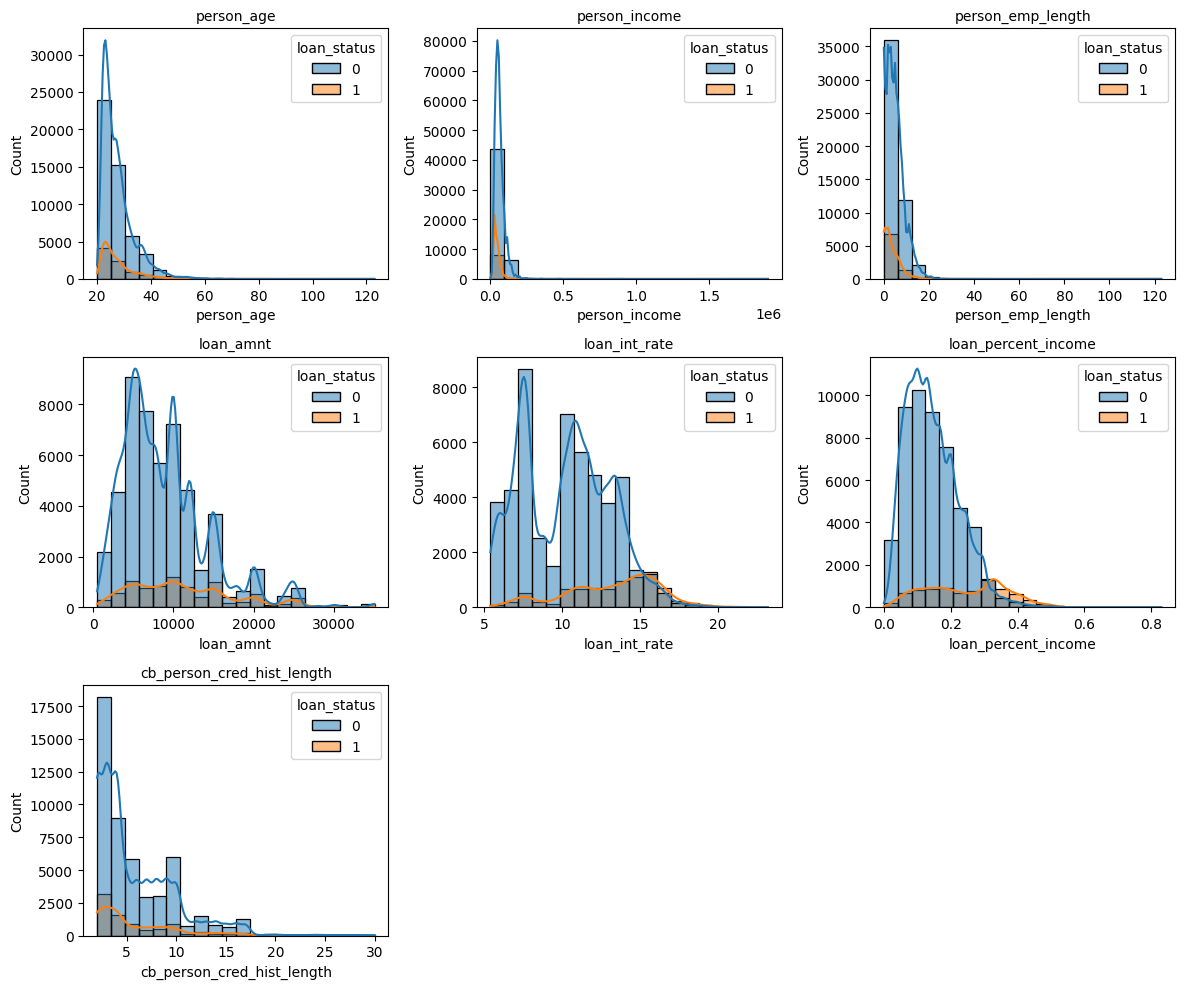

In [12]:
# Cell 6: Visualize numerical features
numerical_features = train.select_dtypes(exclude=["object"]).columns.tolist()
fig, axs = plt.subplots(3, 3, figsize=(12,10))
for feat, ax in zip(numerical_features, axs.ravel()):
    sns.histplot(x=feat, hue=Config.target, data=train, kde=True, bins=20, ax=ax)
    ax.set_title(f"{feat}", fontsize=10)
# Remove the last two unused subplots
for i in range(7, 9):
    fig.delaxes(axs.ravel()[i])
plt.tight_layout()
plt.show()

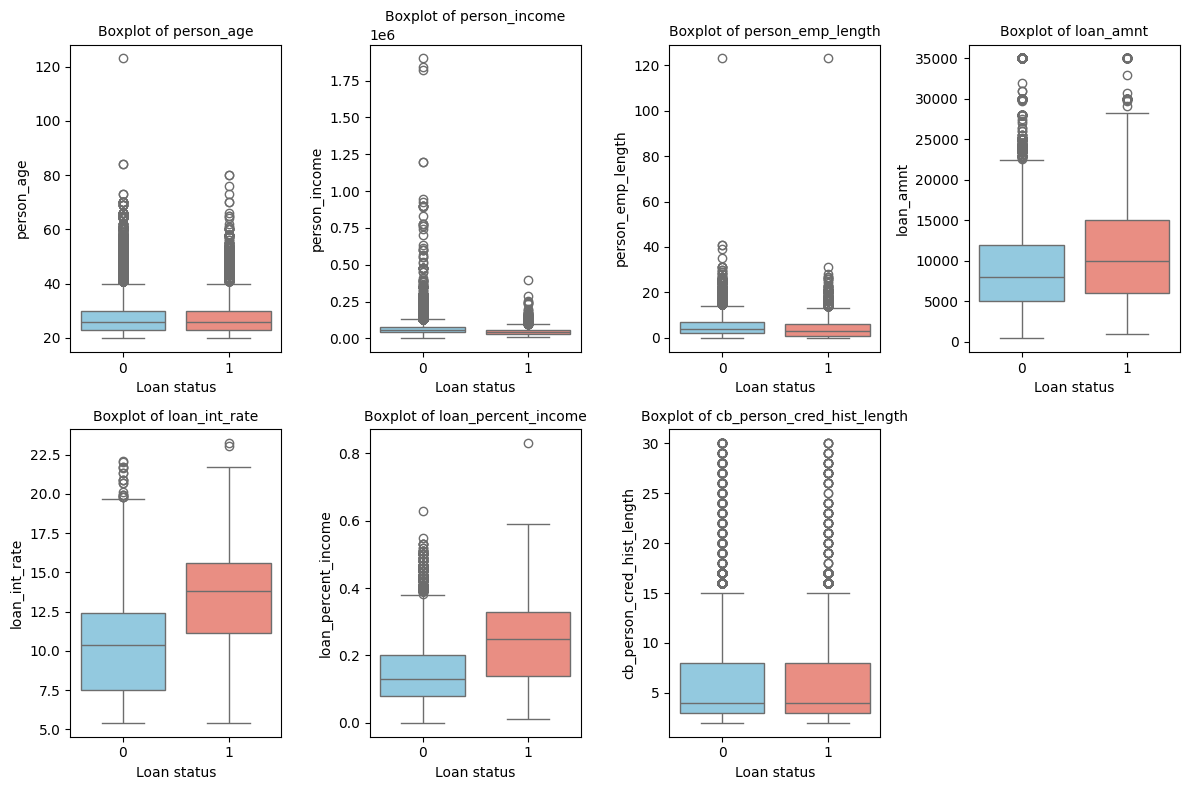

In [13]:
# Cell 7: Box plots for numerical features
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
colors = ['skyblue', 'salmon']  # Colors for 0 and 1 respectively

for feat, ax in zip(numerical_features, axs.ravel()):
    sns.boxplot(x=Config.target, y=feat, data=train, ax=ax, palette=colors)
    ax.set_title(f"Boxplot of {feat}", size=10)
    ax.set_xlabel("Loan status")

fig.delaxes(axs.ravel()[7])
plt.tight_layout()
plt.show()

In [14]:
# Cell 8: Detect outliers
def detect_outliers(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    return df[(df[column] < lower_limit) | (df[column] > upper_limit)]

for feat in numerical_features:
    outliers = detect_outliers(train, feat)
    print(f"Outliers in column {feat}: {outliers.shape[0]}")

Outliers in column person_age: 2446
Outliers in column person_income: 2411
Outliers in column person_emp_length: 1274
Outliers in column loan_amnt: 2045
Outliers in column loan_int_rate: 34
Outliers in column loan_percent_income: 1210
Outliers in column cb_person_cred_hist_length: 1993
Outliers in column loan_status: 8350


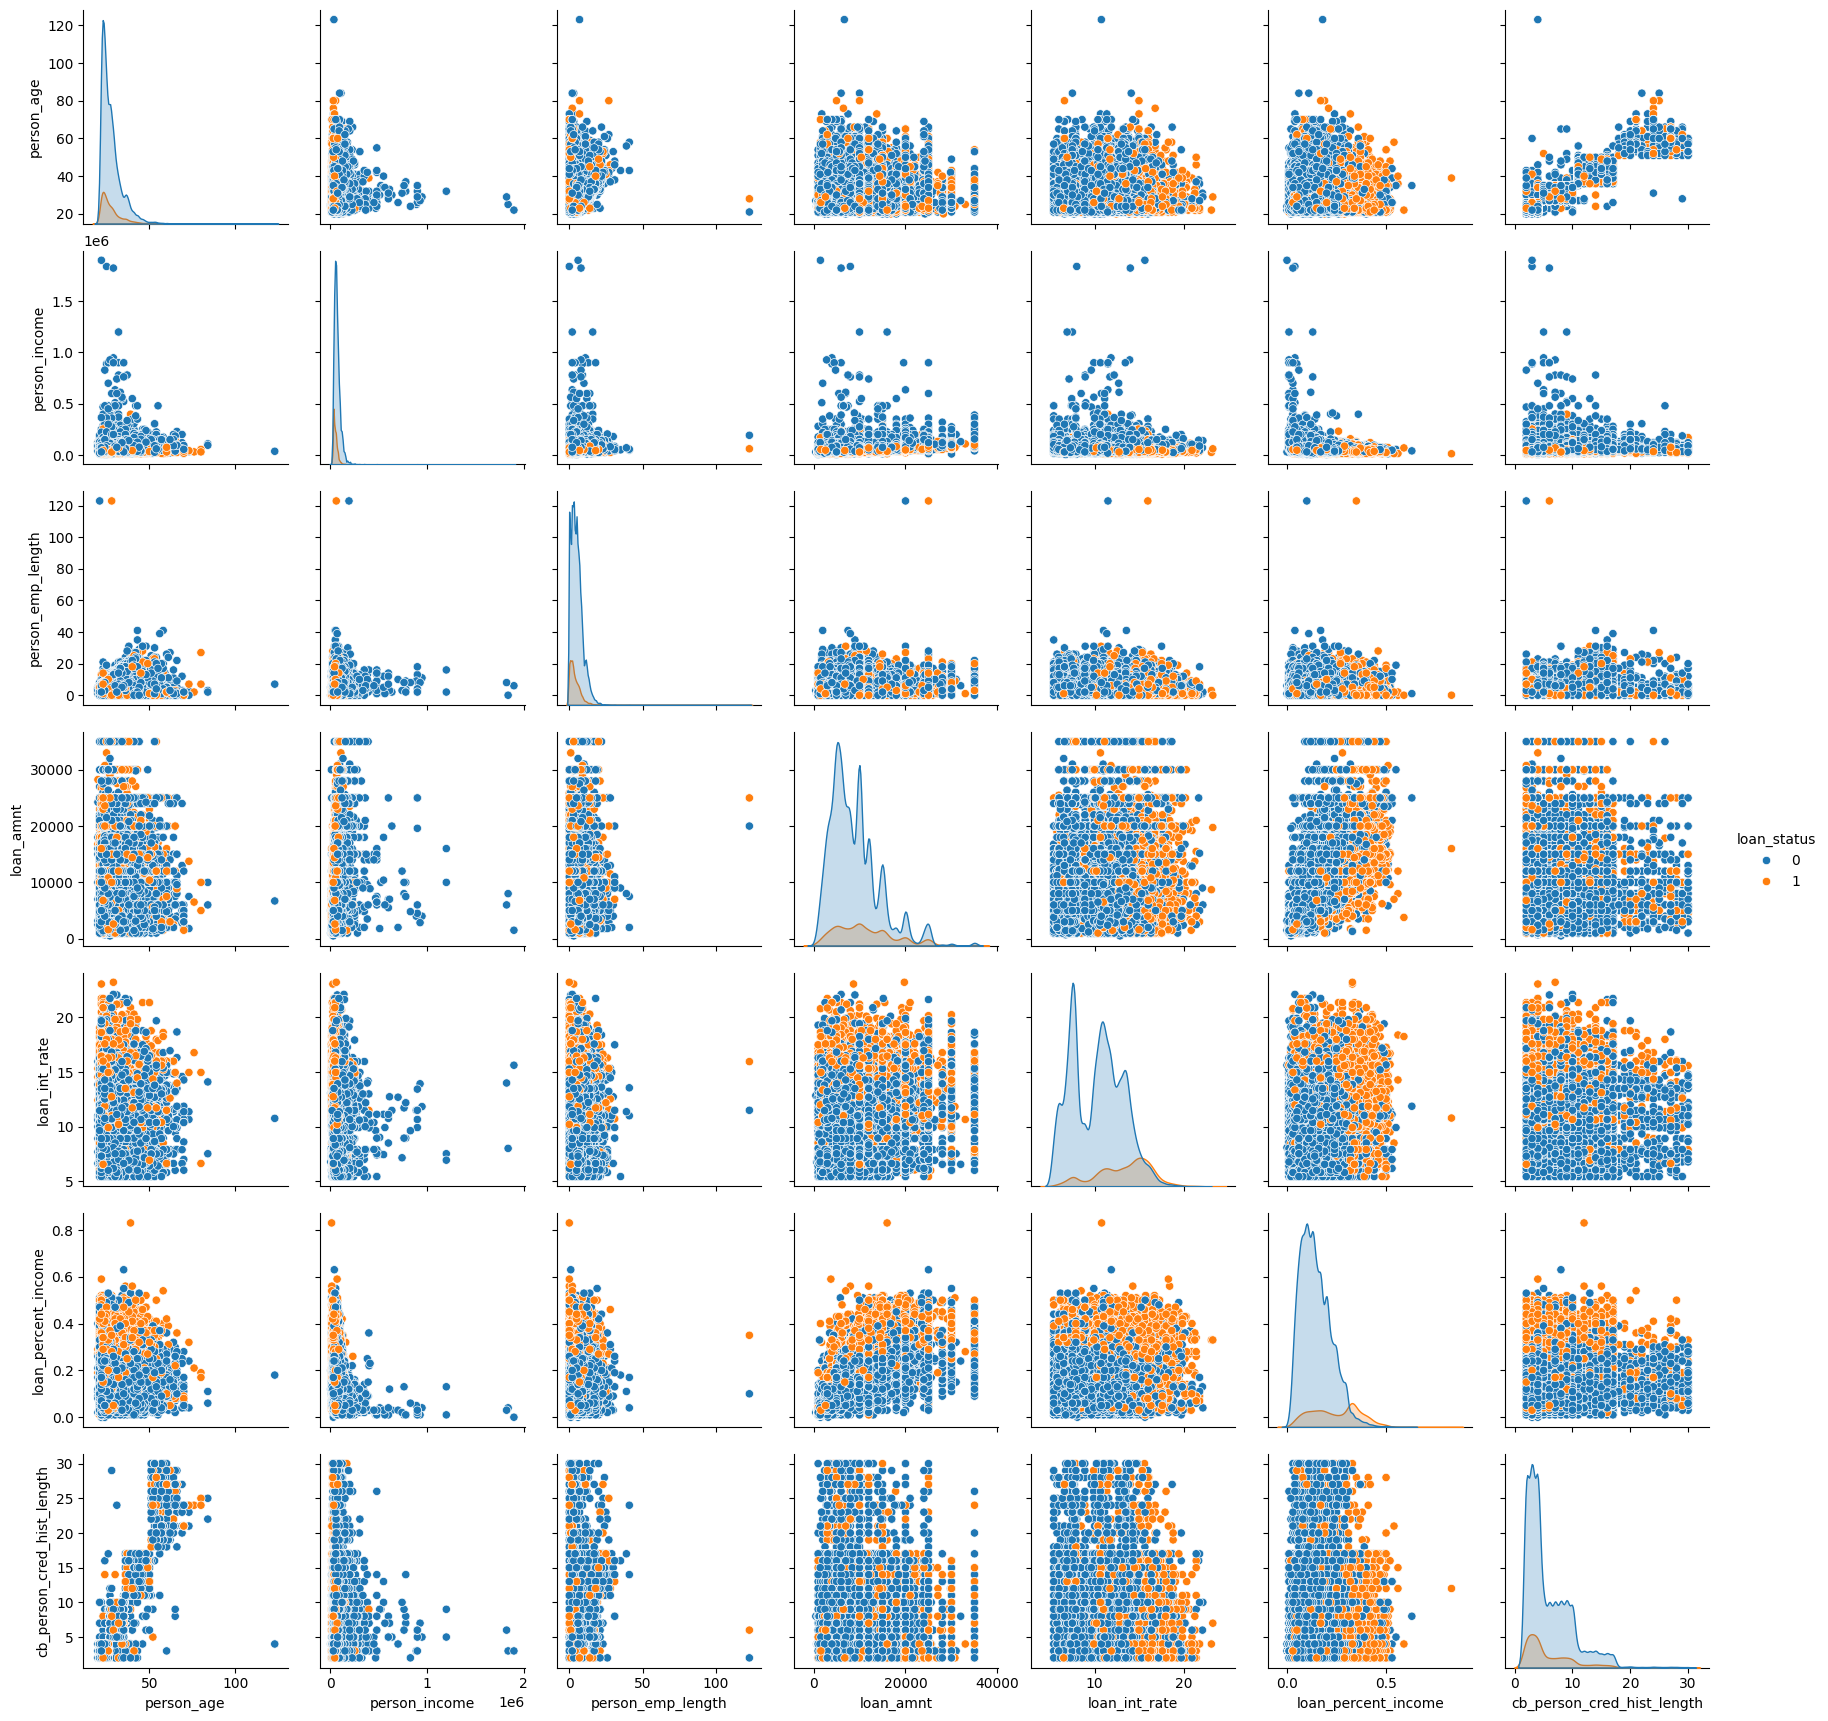

In [15]:
# Cell 9: Pairplot
columns_to_plot = train.select_dtypes(exclude=["object"]).columns.tolist()
sns.pairplot(train[columns_to_plot], hue=Config.target)
plt.show()



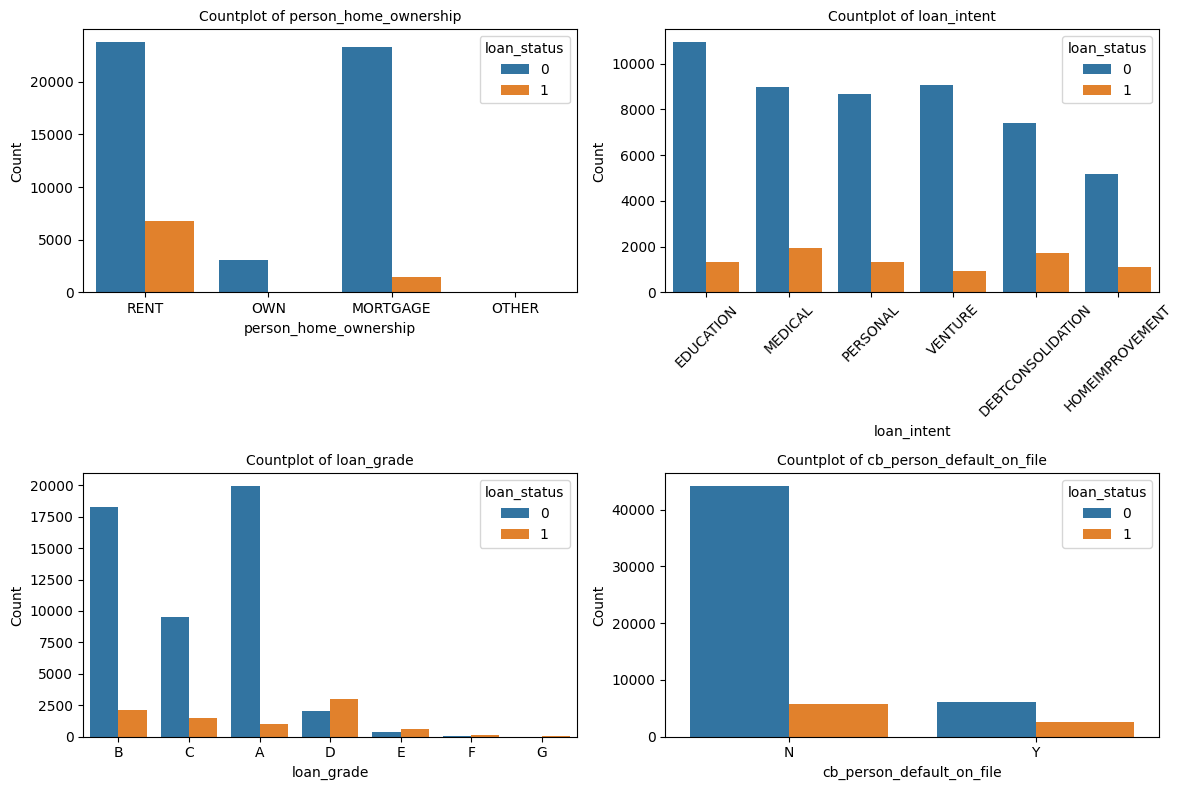

In [16]:
# Cell 10: Visualize categorical features
fig, axs = plt.subplots(2, 2, figsize=(12,8))
for feat, ax in zip(categorical_features, axs.ravel()):
    sns.countplot(data=train, x=feat, hue=Config.target, ax=ax)
    ax.set_title(f"Countplot of {feat}", size=10)
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")
    if feat == "loan_intent":
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Cell 11: Data processing function
def process_data(impute_missing=False, is_for_catboost=False, use_encoding=False):
    # Read the datasets
    train = pd.read_csv(Config.train_path, index_col="id")
    test = pd.read_csv(Config.test_path, index_col="id")
    original = pd.read_csv(Config.original_data_path)
    # Impute missing values (only for original dataset)
    if impute_missing:
        original["person_emp_length"] = original["person_emp_length"].fillna(original["person_emp_length"].median())
        original["loan_int_rate"] = original["loan_int_rate"].fillna(original["loan_int_rate"].median())
    # Define categorical features
    if is_for_catboost:
        categorical_columns = test.columns.tolist()
    else:
        categorical_columns = test.select_dtypes(include=["object"]).columns.tolist()
    # Convert categorical columns to 'category' type
    train[categorical_columns] = train[categorical_columns].astype(str).astype("category")
    test[categorical_columns] = test[categorical_columns].astype(str).astype("category")
    original[categorical_columns] = original[categorical_columns].astype(str).astype("category")
    if use_encoding:
        encoder = OrdinalEncoder()
        train[categorical_columns] = encoder.fit_transform(train[categorical_columns])
        test[categorical_columns] = encoder.transform(test[categorical_columns])
        original[categorical_columns] = encoder.transform(original[categorical_columns])
    # Divide data into X and y sets
    X = train.drop(Config.target, axis=1)
    y = train[Config.target]
    X_test = test
    X_original = original.drop(Config.target, axis=1)
    y_original = original[Config.target]
    if is_for_catboost:
        return X, y, X_test, X_original, y_original, categorical_columns
    else:
        return X, y, X_test, X_original, y_original



In [18]:
# Cell 12: Feature importance using mutual information
X_mi, y_mi, _, _, _ = process_data(use_encoding=True)
mutual_info = mutual_info_classif(X_mi, y_mi, random_state=Config.seed)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=["Mutual Information"])
mutual_info.style.bar(subset=["Mutual Information"], cmap="RdYlGn")

,Mutual Information
person_income,0.097826
loan_int_rate,0.084167
loan_percent_income,0.082536
loan_grade,0.080511
person_home_ownership,0.041433
loan_amnt,0.016160
cb_person_default_on_file,0.014135
person_emp_length,0.008371
loan_intent,0.006237
cb_person_cred_hist_length,0.001656


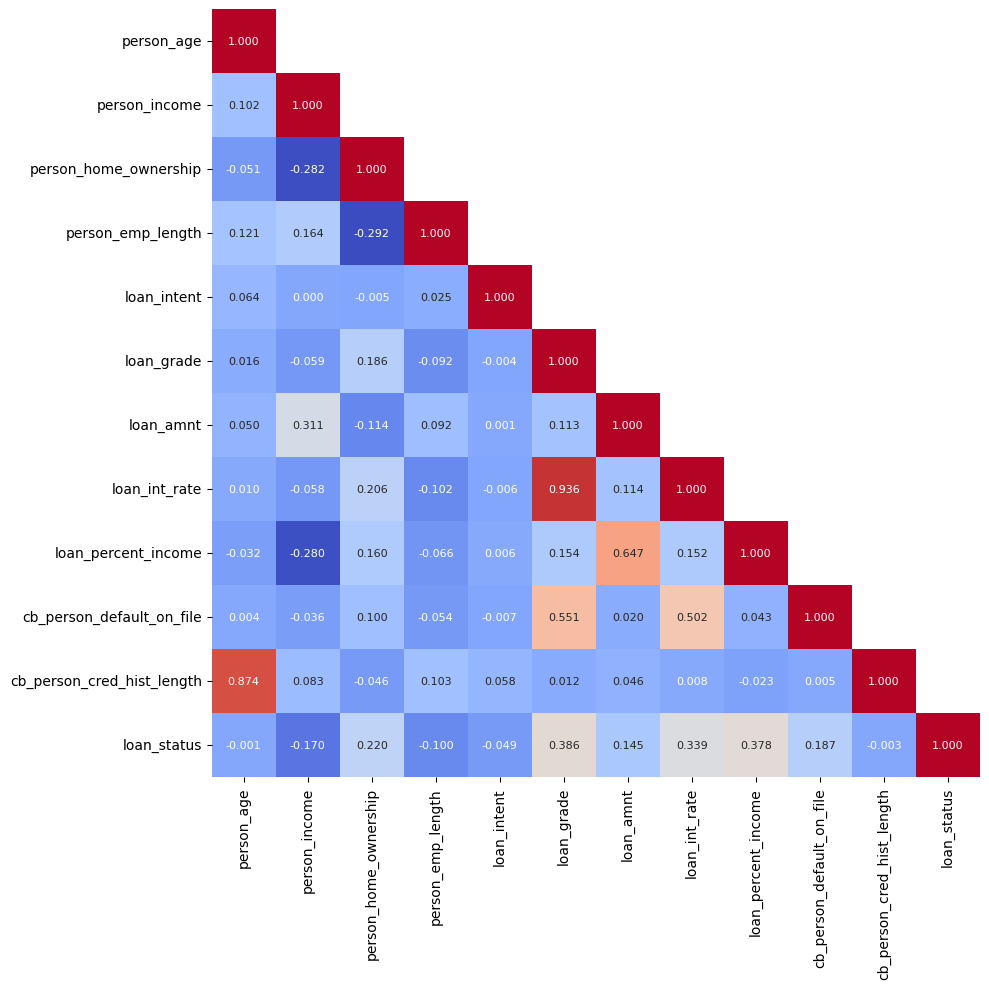

In [19]:
# Cell 13: Correlation heatmap
plt.figure(figsize=(10,10))
corr_train = pd.concat([X_mi, y_mi], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(data=corr_train,
           annot=True,
           fmt=".3f",
           mask=mask_train,
           cmap="coolwarm",
           annot_kws={"size": 8},
           cbar=False)
plt.tight_layout()
plt.show()

In [20]:
# Cell 14: Model training functions
def objective(trial, model, is_catboost=False, is_gradient_boosting=False):
    # Load the data
    if is_catboost:
        X, y, _, X_original, y_original, categorical_features = process_data(impute_missing=True, is_for_catboost=True)
    elif is_gradient_boosting:
        X, y, _, X_original, y_original = process_data(impute_missing=True, use_encoding=True)
    else:
        X, y, _, X_original, y_original = process_data()
    # Combine original
    X_comb = pd.concat([X, X_original], ignore_index=True)
    y_comb = pd.concat([y, y_original], ignore_index=True)
    # Use stratified sampling
    cv = StratifiedKFold(Config.n_folds, shuffle=True,
                        random_state=Config.seed)
    cv_splits = cv.split(X_comb, y_comb)
    scores = []
    for train_idx, val_idx in cv_splits:
        X_fold, X_val_fold = X_comb.iloc[train_idx], X_comb.iloc[val_idx]
        y_fold, y_val_fold = y_comb.iloc[train_idx], y_comb.iloc[val_idx]
        if is_catboost:
            model.fit(X_fold, y_fold, cat_features=categorical_features)
        else:
            model.fit(X_fold, y_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:,1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)
    mean_score = np.mean(scores)
    print(f"Mean AUC score: {mean_score:.5f}")
    return mean_score

def create_model(trial, model_type):
    is_catboost = False
    is_gradient_boosting = False
    if model_type == "xgb":
        params = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "reg_lambda": trial.suggest_float("reg_lambda", 0.3, 6, log=True),
        "gamma": trial.suggest_float("gamma", 0.3, 5, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 4, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 12, 45),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.92),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 2, 5),
        "n_jobs": -1,
        "enable_categorical": True}
        model = XGBClassifier(**params)
    elif model_type == "lgbm":
        params = {"objective": "binary",
          "metric": "auc",
          "verbose": -1,
          "n_jobs": -1,
          "random_state": Config.seed,
          "num_leaves": trial.suggest_int("num_leaves", 10, 200),
          "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
          "num_iterations": trial.suggest_int("numn_iterations", 10, 1000),
          "max_depth": trial.suggest_int("max_depth", 2, 10),
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
          "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
          "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
          "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
          "subsample": trial.suggest_float("subsample", 0.25, 1.0)}
        model = LGBMClassifier(**params)
    elif model_type == "gradientboosting":
        is_gradient_boosting = True
        params = {"random_state": Config.seed,
                  "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                  "max_depth": trial.suggest_int("max_depth", 3, 15),
                  "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
                  "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 30, 150),
                  "min_samples_leaf": trial.suggest_float("min_samples_leaf", 1e-3, 0.2, log=True),
                  "min_samples_split": trial.suggest_float("min_samples_split", 0.1, 0.5, log=True),
                  "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 1e-3, 0.25, log=True),
                  "subsample": trial.suggest_float("subsample", 0.7, 1.0)
                 }
        model = GradientBoostingClassifier(**params)
    elif model_type == "catboost":
        is_catboost = True
        params = {"loss_function": "Logloss",
              "eval_metric": "AUC",
              "verbose": False,
              "random_seed": Config.seed,
              "depth": trial.suggest_int("depth", 2, 10),
              "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
              "iterations": trial.suggest_int("iterations", 10, 1000),
              "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10, log=True),
              "subsample": trial.suggest_float("subsample", 0.25, 1.0),
              "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
              "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0)
             }
        model = CatBoostClassifier(**params)
    return model, is_catboost, is_gradient_boosting

def objective_wrapper(trial, model_type):
    # Create the model based on the model type
    model, is_catboost, is_gradient_boosting = create_model(trial, model_type)
    # Pass the created model to the objective function
    return objective(trial, model, is_catboost, is_gradient_boosting)

In [21]:

# Cell 16: Best parameters for models (after running Optuna)
gb_best_params = {'random_state': Config.seed,
                  'learning_rate': 0.08556786152814144,
                  'max_depth': 11, 'n_estimators': 1130,
                  'max_leaf_nodes': 90,
                  'min_samples_leaf': 0.0025834075077401774,
                  'min_samples_split': 0.11732169002596993,
                  'min_weight_fraction_leaf': 0.0014666658781746856,
                  'subsample': 0.9514006946730825}

xgb_best_params = {'reg_lambda': 2.4405158111921863,
                   'gamma': 0.3982733090695012,
                   'reg_alpha': 0.24107122217235094,
                   'learning_rate': 0.04016333643101095,
                   'max_depth': 7, 'min_child_weight': 13,
                   'subsample': 0.995519109912551,
                   'colsample_bytree': 0.8486105774601723,
                   'n_estimators': 798,
                   'scale_pos_weight': 2.3830062960392415,
                   'enable_categorical': True,
                   'verbosity': 0,
                   'objective': 'binary:logistic',
                   'eval_metric': 'auc',
                   'random_state': Config.seed}

lgbm_best_params = {'num_leaves': 197,
                    'learning_rate': 0.059296275534302084,
                    'num_iterations': 917,
                    'max_depth': 6, 'min_data_in_leaf': 29,
                    'n_estimators': 705,
                    'reg_alpha': 0.03459613662117892,
                    'reg_lambda': 0.0054327372862819304,
                    'colsample_bytree': 0.6139008167954846,
                    'subsample': 0.9643087473729766,
                    'objective': 'binary',
                    'metric': 'auc',
                    'verbose': -1,
                    'n_jobs': -1,
                    'random_state': Config.seed,}

cb_best_params = {'depth': 8,
                  'learning_rate': 0.07665788170871725,
                  'iterations': 566,
                  'reg_lambda': 2.0554245520150745,
                  'subsample': 0.6203466972732931,
                  'min_data_in_leaf': 55,
                  'colsample_bylevel': 0.4561639674406221,
                  'loss_function': 'Logloss',
                  'eval_metric': 'AUC',
                  'verbose': False,
                  'random_seed': Config.seed,}


In [22]:
# Cell 17: Model training class
class Model_training:
    def __init__(self, model, config=Config, is_ensemble_model=False):
        self.model = model
        self.config = Config
        self.is_ensemble_model = is_ensemble_model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f"Training {self.model.__class__.__name__}\n")
        scores = []
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed,
                             shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            if not self.is_ensemble_model:
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
            model = clone(self.model)
            model.fit(X_train, y_train)
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.config.n_folds
                n_iters = model.n_iter_[0]
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            score = roc_auc_score(y_val, y_pred_probs[:,1])
            scores.append(score)
            if self.is_ensemble_model:
                print(f"Fold {fold_idx + 1} - AUC: {score:.5f} ({n_iters} iterations)")
            else:
                print(f"Fold {fold_idx + 1} - AUC: {score:.5f}")
        overall_score = roc_auc_score(y, oof_pred_probs[:,1])
        print(f"\n Overall: {overall_score:.5f} | Average score: {np.mean(scores):.5f} ± {np.std(scores):.5f}")
        if self.is_ensemble_model:
            return scores, coeffs
        else:
            return oof_pred_probs[:,1], test_pred_probs[:, 1], scores



In [23]:
# Cell 18: Train models
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

X, y, X_test, X_original, y_original = process_data(impute_missing=True, use_encoding=True)
gb_model = GradientBoostingClassifier(**gb_best_params)
gb_trainer = Model_training(gb_model)
oof_pred_probs["GradientBoosting"], test_pred_probs["GradientBoosting"], scores["GradientBoosting"] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)


Training GradientBoostingClassifier

Fold 1 - AUC: 0.95991
Fold 2 - AUC: 0.96789
Fold 3 - AUC: 0.96280
Fold 4 - AUC: 0.96488
Fold 5 - AUC: 0.96390

 Overall: 0.96387 | Average score: 0.96388 ± 0.00261


In [24]:
X, y, X_test, X_original, y_original = process_data(use_encoding = False, impute_missing=False)
xgb_model = XGBClassifier(**xgb_best_params)
xgb_trainer = Model_training(xgb_model)
oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

Fold 1 - AUC: 0.95685
Fold 2 - AUC: 0.96598
Fold 3 - AUC: 0.95888
Fold 4 - AUC: 0.96014
Fold 5 - AUC: 0.96152

 Overall: 0.96064 | Average score: 0.96067 ± 0.00306


In [25]:
X, y, X_test, X_original, y_original = process_data()
lgbm_model = LGBMClassifier(**lgbm_best_params)
lgbm_trainer = Model_training(lgbm_model)
oof_pred_probs["LightGBM"],test_pred_probs["LightGBM"],scores["LightGBM"] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

Fold 1 - AUC: 0.95805
Fold 2 - AUC: 0.96790
Fold 3 - AUC: 0.96091
Fold 4 - AUC: 0.96251
Fold 5 - AUC: 0.96160

 Overall: 0.96216 | Average score: 0.96219 ± 0.00322


In [26]:
X, y, X_test, X_original, y_original, categorical_columns = process_data(impute_missing=True, is_for_catboost=True)
cb_model = CatBoostClassifier(**cb_best_params, cat_features=categorical_columns)
cb_trainer = Model_training(cb_model)
oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier

Fold 1 - AUC: 0.96345
Fold 2 - AUC: 0.97204
Fold 3 - AUC: 0.96858
Fold 4 - AUC: 0.97051
Fold 5 - AUC: 0.96688

 Overall: 0.96824 | Average score: 0.96829 ± 0.00298


In [27]:
# Cell 19: Hill climbing ensemble
hill_climb_test_pred_probs, hill_climb_oof_pred_probs = climb_hill(
    train=train,
    oof_pred_df=pd.DataFrame(oof_pred_probs),
    test_pred_df=pd.DataFrame(test_pred_probs),
    target=Config.target,
    objective="maximize",
    eval_metric=partial(roc_auc_score),
    negative_weights=True,
    precision=0.001,
    plot_hill=True,
    plot_hist=False,
    return_oof_preds=True)



   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (4 total): 

CatBoost:         0.96824 (best solo model)
GradientBoosting: 0.96387
LightGBM:         0.96216
XGBoost:          0.96064

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: LightGBM | Best weight: 0.263 | Best roc_auc_score: 0.96913
Iteration: 2 | Model added: GradientBoosting | Best weight: 0.087 | Best roc_auc_score: 0.96918
Iteration: 3 | Model added: XGBoost | Best weight: 0.010 | Best roc_auc_score: 0.96918


In [28]:
# Cell 20: Create submission file
sub_df = pd.read_csv(Config.sample_sub_path)
sub_df[Config.target] = hill_climb_test_pred_probs
sub_df.to_csv("submission_hill_climb_ensemble.csv", index=False)
sub_df.to_csv("submission.csv", index=False)
sub_df.head()



,id,loan_status
0,58645,0.999476
1,58646,0.021505
2,58647,0.482322
3,58648,0.006667
4,58649,0.040661


In [29]:
# Cell 21: User input function
def get_user_input():
    print("Please enter the following information for loan approval prediction:")

    person_age = int(input("Age: "))
    person_income = float(input("Annual Income: "))
    person_home_ownership = input("Home Ownership (RENT/MORTGAGE/OWN/OTHER): ")
    person_emp_length = float(input("Employment Length (years): "))
    loan_intent = input("Loan Intent (PERSONAL/EDUCATION/MEDICAL/VENTURE/HOME_IMPROVEMENT/DEBT_CONSOLIDATION): ")
    loan_grade = input("Loan Grade (A/B/C/D/E/F/G): ")
    loan_amnt = float(input("Loan Amount: "))
    loan_int_rate = float(input("Loan Interest Rate: "))
    loan_percent_income = float(input("Loan Percent Income: "))
    cb_person_default_on_file = input("Has the person defaulted before? (Y/N): ")
    cb_person_cred_hist_length = int(input("Credit History Length (years): "))

    user_data = pd.DataFrame({
        'person_age': [person_age],
        'person_income': [person_income],
        'person_home_ownership': [person_home_ownership],
        'person_emp_length': [person_emp_length],
        'loan_intent': [loan_intent],
        'loan_grade': [loan_grade],
        'loan_amnt': [loan_amnt],
        'loan_int_rate': [loan_int_rate],
        'loan_percent_income': [loan_percent_income],
        'cb_person_default_on_file': [cb_person_default_on_file],
        'cb_person_cred_hist_length': [cb_person_cred_hist_length]
    })

    return user_data

In [30]:
# Cell 22: Prediction function
def predict_loan_approval(user_data, model, categorical_columns):
    # Ensure categorical columns are of type 'category' and convert floats to strings
    for col in categorical_columns:
        if user_data[col].dtype == 'float64':
            user_data[col] = user_data[col].astype(str)
        user_data[col] = user_data[col].astype('category')

    # Make prediction
    prediction = model.predict_proba(user_data)
    return prediction[0][1]  # Return probability of approval

In [31]:
# Cell 3-22: [Keep all the existing code for these cells as is]
# Cell 23: Main execution
if __name__ == "__main__":
    # Get user input
    user_data = get_user_input()
    # Use the CatBoost model for prediction
    cb_model = CatBoostClassifier(**cb_best_params, cat_features=categorical_columns)
    cb_model.fit(X, y)  # Assuming X and y are your full training data
    # Save the trained model
    cb_model.save_model("catboost_model.cbm")
    approval_probability = predict_loan_approval(user_data, cb_model, categorical_columns)
    print(f"\nLoan Approval Probability: {approval_probability:.2%}")
    if approval_probability > 0.5:
        print("Based on the provided information, the loan is likely to be approved.")
    else:
        print("Based on the provided information, the loan is likely to be denied.")



Please enter the following information for loan approval prediction:
Age: 23
Annual Income: 69000
Home Ownership (RENT/MORTGAGE/OWN/OTHER): RENT
Employment Length (years): 3
Loan Intent (PERSONAL/EDUCATION/MEDICAL/VENTURE/HOME_IMPROVEMENT/DEBT_CONSOLIDATION): HOME_IMPROVEMENT
Loan Grade (A/B/C/D/E/F/G): F
Loan Amount: 25000
Loan Interest Rate: 15.76
Loan Percent Income: 0.36
Has the person defaulted before? (Y/N): N
Credit History Length (years): 2

Loan Approval Probability: 98.79%
Based on the provided information, the loan is likely to be approved.


In [32]:
!pip install streamlit
!npm install localtunnel


added 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


In [33]:
%%writefile Loan_Approval_Predictions.py
import streamlit as st
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import plotly.graph_objects as go
import plotly.express as px

# Load the trained CatBoost model
@st.cache_resource
def load_model():
    model = CatBoostClassifier()
    model.load_model("catboost_model.cbm")
    return model

model = load_model()

# Define categorical columns
categorical_columns = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

st.title("Loan Approval Prediction App 💼💰")
st.markdown("""
This app predicts the probability of loan approval based on various factors.
Fill in the form below to get your loan approval prediction!
""")

# Create input form
st.header("Applicant Information")
col1, col2 = st.columns(2)
with col1:
    person_age = st.number_input("Age", min_value=18, max_value=100, value=30)
    person_income = st.number_input("Annual Income ($)", min_value=0, value=50000)
    person_home_ownership = st.selectbox(
        "Home Ownership",
        options=["RENT", "MORTGAGE", "OWN", "OTHER"]
    )
    person_emp_length = st.number_input("Employment Length (years)", min_value=0.0, max_value=50.0, value=5.0)
    loan_intent = st.selectbox(
        "Loan Intent",
        options=["PERSONAL", "EDUCATION", "MEDICAL", "VENTURE", "HOME_IMPROVEMENT", "DEBT_CONSOLIDATION"]
    )
with col2:
    loan_grade = st.selectbox("Loan Grade", options=["A", "B", "C", "D", "E", "F", "G"])
    loan_amnt = st.number_input("Loan Amount ($)", min_value=1000, max_value=1000000, value=10000)
    loan_int_rate = st.slider("Loan Interest Rate (%)", min_value=1.0, max_value=30.0, value=10.0)
    loan_percent_income = st.slider("Loan Percent Income", min_value=0.0, max_value=1.0, value=0.1)
    cb_person_default_on_file = st.selectbox("Has the person defaulted before?", options=["Y", "N"])
    cb_person_cred_hist_length = st.number_input("Credit History Length (years)", min_value=0, max_value=50, value=5)

# Prediction button
if st.button("Predict Loan Approval"):
    # Prepare user input for prediction
    user_data = pd.DataFrame({
        'person_age': [str(person_age)],
        'person_income': [str(person_income)],
        'person_home_ownership': [person_home_ownership],
        'person_emp_length': [str(person_emp_length)],
        'loan_intent': [loan_intent],
        'loan_grade': [loan_grade],
        'loan_amnt': [str(loan_amnt)],
        'loan_int_rate': [str(loan_int_rate)],
        'loan_percent_income': [str(loan_percent_income)],
        'cb_person_default_on_file': [cb_person_default_on_file],
        'cb_person_cred_hist_length': [str(cb_person_cred_hist_length)]
    })

    # Convert all columns to strings (categorical)
    for col in categorical_columns:
        user_data[col] = user_data[col].astype(str)

    # Create CatBoost Pool with all columns as categorical features
    pool = Pool(user_data, cat_features=categorical_columns)

    try:
        # Make prediction
        approval_probability = model.predict_proba(pool)[0][1]

        # Create a gauge chart for the approval probability
        fig = go.Figure(go.Indicator(
            mode="gauge+number",
            value=approval_probability * 100,
            domain={'x': [0, 1], 'y': [0, 1]},
            title={'text': "Approval Probability", 'font': {'size': 24}},
            gauge={
                'axis': {'range': [0, 100], 'tickwidth': 1, 'tickcolor': "darkblue"},
                'bar': {'color': "darkblue"},
                'bgcolor': "white",
                'borderwidth': 2,
                'bordercolor': "gray",
                'steps': [
                    {'range': [0, 50], 'color': 'red'},
                    {'range': [50, 75], 'color': 'yellow'},
                    {'range': [75, 100], 'color': 'green'}],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 50}}))

        st.plotly_chart(fig)

        # Display result
        st.subheader("Loan Approval Prediction")
        if approval_probability > 0.5:
            st.success(f"Congratulations! Your loan is likely to be approved with a {approval_probability:.2%} probability.")
        else:
            st.error(f"We're sorry, but your loan is likely to be denied. The approval probability is {approval_probability:.2%}.")

        # Display important factors
        st.subheader("Important Factors")
        feature_importance = model.get_feature_importance(type='ShapValues', data=pool)
        feature_importance_df = pd.DataFrame({
            'Feature': user_data.columns,
            'Importance': np.abs(feature_importance[0]).mean(axis=0)
        }).sort_values('Importance', ascending=False)

        # 1. Horizontal Bar Chart
        fig1 = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h',
                      title="Feature Importance - Bar Chart",
                      labels={'Importance': 'Importance Score', 'Feature': 'Feature Name'},
                      color='Importance', color_continuous_scale='Viridis')
        fig1.update_layout(coloraxis_colorbar=dict(title="Importance"))
        st.plotly_chart(fig1)

        # 2. Treemap
        fig2 = px.treemap(feature_importance_df, path=['Feature'], values='Importance',
                          title="Feature Importance - Treemap",
                          color='Importance', color_continuous_scale='Turbo')
        fig2.update_layout(coloraxis_colorbar=dict(title="Importance"))
        st.plotly_chart(fig2)

        # 3. Radar Chart
        top_5_features = feature_importance_df.head()
        fig3 = go.Figure()
        fig3.add_trace(go.Scatterpolar(
            r=top_5_features['Importance'],
            theta=top_5_features['Feature'],
            fill='toself',
            line=dict(color='rgba(255, 0, 0, 0.8)'),
            fillcolor='rgba(255, 0, 0, 0.3)'
        ))
        fig3.update_layout(
            polar=dict(radialaxis=dict(visible=True, range=[0, top_5_features['Importance'].max()])),
            showlegend=False,
            title="Top 5 Feature Importance - Radar Chart"
        )
        st.plotly_chart(fig3)

        # 4. Bubble Chart
        fig4 = px.scatter(feature_importance_df, x="Feature", y="Importance",
                          size="Importance", color="Feature",
                          hover_name="Feature", size_max=60,
                          title="Feature Importance - Bubble Chart",
                          color_discrete_sequence=px.colors.qualitative.Bold)
        fig4.update_layout(xaxis={'categoryorder':'total descending'})
        st.plotly_chart(fig4)

        # 5. Animated Bar Chart
        max_importance = feature_importance_df['Importance'].max()
        feature_importance_df['Importance'] = feature_importance_df['Importance'] / max_importance * 2 - 1

        fig5 = px.bar(feature_importance_df, x="Importance", y="Feature", orientation='h',
                      title="Feature Importance - Animated Bar Chart",
                      animation_frame="Feature", animation_group="Feature",
                      range_x=[-1, 1],
                      color="Feature", color_discrete_sequence=px.colors.qualitative.Pastel)
        fig5.update_layout(showlegend=False, xaxis_title="Importance Score", yaxis_title="Feature")
        st.plotly_chart(fig5)

    except Exception as e:
        st.error(f"An error occurred while making the prediction: {str(e)}")
        st.error("Please check if the model file 'catboost_model.cbm' is present in the correct location.")

st.markdown("""
### How to interpret the results:
- A probability above 50% suggests a higher likelihood of loan approval.
- The gauge chart visually represents the approval probability.
- The feature importance charts show which factors had the most impact on the prediction.

Please note that this is a predictive model and the actual loan approval decision may involve additional factors and human judgment.
""")

Writing Loan_Approval_Predictions.py


In [34]:
!curl ipv4.icanhazip.com

34.82.233.143


In [35]:
!streamlit run app6.py &>./logs.txt & npx localtunnel --port 8501 -y

your url is: https://floppy-monkeys-wave.loca.lt
^C
